In [27]:
from astropy.table import Table, vstack, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval
from astropy.table import join
import centroid_functions as func 
import numpy as np


## Create groups A and B 

In [28]:
N = 20 # how many donuts in each group ? 

instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'



def find_hot_pixels(donutStamps, threshold=3):
    zscale = ZScaleInterval()
    hot_dic = {'i':[], 'vmax':[], 'gmax':[]}
    for i in range(len(donutStamps)):
        stamp = donutStamps[i]
        data = stamp.stamp_im.getImage().getArray()
        # find global min/max 
        gmin, gmax = np.min(data), np.max(data)

        # find zscale min, max
        vmin, vmax = zscale.get_limits(data)

        if gmax > threshold*vmax:
            print(i, vmax, gmax, 'potential hot pixel ')
            hot_dic['i'].append(i)
            hot_dic['vmax'].append(vmax)
            hot_dic['gmax'].append(gmax)
    if len(hot_dic['i'])==0:
        print(f'no hot pixels found where global max > {threshold} zscale vmax ')
        
    return hot_dic
    
mag = 16 
for sensor in ['R40','R44','R04']:

#for mag in range(15,20):
    repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/phosimData/'
    print('\n',repo_dir)

    # read in the donuts 
    donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)

    # create a donut info  table 
    donut_info = {}
    for label, donutStamps in zip(['extra','intra'],
                                  [donutStampsExtra, donutStampsIntra]):
        donut_info[label] = {'idToDonutStamps':[],
                           'fieldX':[],
                           'fieldY':[],
                           'fieldR':[],
                             'x':[],
                             'y':[]
                           }

        for i in range(len(donutStamps)):
            stamp =  donutStamps[i]
            fieldX,fieldY = stamp.calcFieldXY()[::-1]  # NB: this is the output of 
            # field_x, field_y = det.transform(self.centroid_position, PIXELS, FIELD_ANGLE)
            # i.e. in degrees 
            fieldR = np.sqrt(fieldX**2. + fieldY**2.)
            x,y = stamp.centroid_position
            donut_info[label]['x'].append(x)
            donut_info[label]['y'].append(y)
            donut_info[label]['idToDonutStamps'].append(i)
            donut_info[label]['fieldX'].append(fieldX)
            donut_info[label]['fieldY'].append(fieldY)
            donut_info[label]['fieldR'].append(fieldR)
        d = Table(data=donut_info[label], 
                  names=['idToDonutStamps','fieldR','fieldX','fieldY','x', 'y'])
        d.sort('fieldR') 
        # sort by field distance - crucial for choosing the donut 
        # groups in two opposing corners 
        donut_info[label]['table'] = d

        # add info about hot pixels 
        print(label)
        hotPixel = find_hot_pixels(donutStamps)
        donut_info[label]['table']['hotPixel'] = False
        mask = np.in1d(donut_info[label]['table']['idToDonutStamps'], hotPixel['i'])
        donut_info[label]['table']['hotPixel'][mask] = True 
        
    # first stack all the donut data together   
    donut_intra_table = donut_info['intra']['table']
    donut_intra_table['defocal'] = 'intra'

    donut_extra_table = donut_info['extra']['table']
    donut_extra_table['defocal'] = 'extra'

    donut_table = vstack([donut_intra_table, donut_extra_table])

    # combine donut and OPD info
    # read the information about  OPD grid location 
    info = Table.read(f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_sensors.txt',
              format='ascii.commented_header', )

    # add OPD info crossmatching by position 
    donut_coord = SkyCoord(ra=donut_table['fieldX']*u.degree, 
                           dec=donut_table['fieldY']*u.degree)
    opd_coord = SkyCoord(ra=info['Ra_deg']*u.degree, 
                          dec=info['Decl_deg']*u.degree)
    idx, sep2d, dist3d = donut_coord.match_to_catalog_sky(opd_coord)

    # idx are from donut_coord to matching opd_coord 
    donut_opd_table = hstack([donut_table, info[idx]], table_names = ['donut','opd'])
    donut_opd_table['sep2d'] = sep2d *3600

    # rename the Id as the Id to OPD grid 
    donut_opd_table.rename_column('Id', 'idToOpdGrid')

    # create groups A and B 
    donut_opd_table['group'] = ''
    
    for defocal in ['intra','extra']: 
        # select defocal and remove hot pixel ones 
        m1 = donut_opd_table['defocal'] == defocal
        m2 = donut_opd_table['hotPixel'] == False
        m = m1&m2 

        # subgroups
        groupIdsA = donut_opd_table[m][:N]['idToOpdGrid']
        groupIdsB = donut_opd_table[m][-N:]['idToOpdGrid']

        # select where ids are 
        m1 = np.in1d(donut_opd_table['idToOpdGrid'].value, groupIdsA.value)
        print(label, 'A', np.sum(m1))
        donut_opd_table['group'][m1] = 'A'

        m1 = np.in1d(donut_opd_table['idToOpdGrid'].value, groupIdsB.value)
        print(label, 'B', np.sum(m1))
        donut_opd_table['group'][m1] = 'B'

    # Save the donut opd table
    fname = f'DM-36218/wfs_grid_{mag}_{sensor}_donut_info_opd.txt'
    donut_opd_table.write(fname,format='ascii', overwrite=True)
    print(f'Saved as {fname}')



/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/
no hot pixels found where global max > 3 zscale vmax 
no hot pixels found where global max > 3 zscale vmax 
intra A 20
intra B 20
intra A 20
intra B 20
Saved as DM-36218/wfs_grid_16_R40_donut_info_opd.txt
/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/
no hot pixels found where global max > 3 zscale vmax 
no hot pixels found where global max > 3 zscale vmax 
intra A 20
intra B 20
intra A 20
intra B 20
Saved as DM-36218/wfs_grid_16_R44_donut_info_opd.txt
/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/
no hot pixels found where global max > 3 zscale vmax 
35 159.59721 32581.256 potential hot pixel 
63 151.89282 34083.59 potential hot pixel 
intra A 20
intra B 20
intra A 20
intra B 20
Saved as DM-36218/wfs_grid_16_R04_donut_info_opd.txt


## Run algorithm for these donut pairs 

In [16]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.patheffects as patheffects

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)

from lsst.ts.wep.task.DonutStamps import DonutStamp, DonutStamps
from lsst.ts.wep.task.EstimateZernikesCwfsTask import (
    EstimateZernikesCwfsTask,
    EstimateZernikesCwfsTaskConfig,
)

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom as cameraGeom
from lsst.afw.cameraGeom import FOCAL_PLANE, PIXELS, FIELD_ANGLE
from lsst.geom import Point2D

from astropy.visualization import ZScaleInterval

import centroid_functions as func 
import algoritm_functions as algo_func


In [17]:
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [60]:



instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
instName='lsst'
opticalModel = 'offAxis'
sizeInPix = 160  # aka donutStamps
solver = 'exp' # by default
debugLevel = 0 # 1 to 3


for sensor in ['R00','R04','R40','R44']:
    mag=16
#for mag in range(15,20):
    repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/phosimData/'
    print(repo_dir)
    
    # read the donut groups
    fname = f'DM-36218/wfs_grid_{mag}_{sensor}_donut_info_opd.txt'
    print(fname)
    donut_opd = Table.read(fname,format='ascii')


    # read in the donuts 
    donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)
    # this is only needed to get the pixel scale 
    extraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)
    pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
    
    configDir = getConfigDir()
    algoDir = os.path.join(configDir, "cwfs", "algo")

    # inside wfEsti = WfEstimator(instDir, algoDir)
    centroidFindType = CentroidFindType.RandomWalk
    camType = getCamType(instName)
    #defocalDisInMm = getDefocalDisInMm(instName)

    # fit one donut pair 
    for name in 'AB':
        # select donuts in a given group
        m1 = donut_opd['group'] == name
        
        m2 = donut_opd['defocal'] =='intra'
        intra = donut_opd[m1&m2]['idToDonutStamps']
        
        m2 = donut_opd['defocal'] =='extra'
        extra = donut_opd[m1&m2]['idToDonutStamps']
        # N donuts in each group
        for k in range(len(intra)):
            i = extra[k]
            j = intra[k]

            # skip if already calculated 
            doCoCenter = False
            if doCoCenter :
                coCenterText = 'doCocenter'
            else:
                coCenterText = 'noCocenter'

            fname = f'store_wfsGrid_{mag}_{sensor}_extra-{i}_intra-{j}_{coCenterText}.npy'
            fpath = os.path.join('DM-36218',fname)
            if os.path.exists(fpath):
                print(f'{fpath} already exists, skipping')

            else:
                donutExtra = donutStampsExtra[i]
                donutIntra = donutStampsIntra[j]

                # this is part of the init
                inst = Instrument()
                algo = Algorithm(algoDir)

                # inside estimateZernikes()

                # inside wfEsti.config
            #     inst.config(camType, sizeInPix, 
            #                 announcedDefocalDisInMm = defocalDisInMm)
                inst.configFromFile(sizeInPix, camType)

                # choose the solver for the algorithm
                algo.config(solver, inst, debugLevel=debugLevel)

                imgIntra = CompensableImage(centroidFindType=centroidFindType)
                imgExtra = CompensableImage(centroidFindType=centroidFindType)

                # Inside EstimateZernikesBase
                # Transpose field XY because CompensableImages below are transposed
                # so this gets the correct mask orientation in Algorithm.py
                fieldXYExtra = donutExtra.calcFieldXY()[::-1]
                fieldXYIntra = donutIntra.calcFieldXY()[::-1]

                camera = donutExtra.getCamera() # same camera for both donuts
                detectorExtra = camera.get(donutExtra.detector_name)
                detectorIntra = camera.get(donutIntra.detector_name)

                # Rotate any sensors that are not lined up with the focal plane.
                # Mostly just for the corner wavefront sensors. The negative sign
                # creates the correct rotation based upon closed loop tests
                # with R04 and R40 corner sensors.
                eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
                eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

                # now inside  `wfEsti.setImg` method,
                # which inherits from `CompensableImage`
                imgExtra.setImg(fieldXYExtra,
                                DefocalType.Extra,
                                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

                imgIntra.setImg(fieldXYIntra,
                                DefocalType.Intra,
                                image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)


                # run the algorithm with unstacked images 
                algo, store = algo_func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                                          tol=1e-3,doCoCenter=doCoCenter)

                print(f'Saved as {fpath}')

                np.save(fpath, store, )



/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/
DM-36218/wfs_grid_16_R00_donut_info_opd.txt
Saved as DM-36218/store_wfsGrid_16_R00_extra-0_intra-103_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-64_intra-29_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-53_intra-43_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-63_intra-30_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-102_intra-44_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-77_intra-5_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-101_intra-31_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-62_intra-45_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-87_intra-6_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-76_intra-20_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-100_intra-32_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R00_extra-86_intra-46_noCocenter.npy
Saved as DM-36218/stor

Saved as DM-36218/store_wfsGrid_16_R40_extra-31_intra-75_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R40_extra-45_intra-100_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R40_extra-6_intra-62_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R40_extra-20_intra-86_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R40_extra-30_intra-76_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R40_extra-44_intra-63_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R40_extra-5_intra-101_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R40_extra-29_intra-1_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R40_extra-43_intra-64_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R40_extra-104_intra-0_noCocenter.npy
/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/
DM-36218/wfs_grid_16_R44_donut_info_opd.txt
Saved as DM-36218/store_wfsGrid_16_R44_extra-0_intra-103_noCocenter.npy
Saved as DM-36218/store_wfsGrid_16_R44_extra-64_intra-29_noCocenter.npy
Saved as DM-36218/store_

# Run stacking within A and within B (per sensor)

In [2]:
import numpy as np 
a = np.array([[1,2,3],
            [0,1,2],
            [20,30,40]])

b  = np.array([[1.2,2.2,3.2],
             [0,0,0],
             [21,33,44]])



In [12]:
c = [a,b]
np.shape(c)

(2, 3, 3)

In [5]:
np.mean([a,b],axis=0)

array([[ 1.1,  2.1,  3.1],
       [ 0. ,  0.5,  1. ],
       [20.5, 31.5, 42. ]])

In [19]:
np.zeros?

In [20]:
N=2
c = np.zeros(shape=(N,3,3))
for i,arr in zip(range(N), [a,b]):
    c[i] = arr

In [22]:
np.mean(c,axis=0)

array([[ 1.1,  2.1,  3.1],
       [ 0. ,  0.5,  1. ],
       [20.5, 31.5, 42. ]])

In [23]:
np.sum(c, axis=0)

array([[ 2.2,  4.2,  6.2],
       [ 0. ,  1. ,  2. ],
       [41. , 63. , 84. ]])

In [61]:
def stack_donuts_new(donutStamps, N=2, indices = None, pixel_stack = 'sum' 
            ):
    '''
    donutStamps: a collection of  donut stamps
    N : up to how many donuts to stack together
    indices:  which indices to donutStamps should be stacked 
        (mutually exclusive with N)
    pixel_stack : str, whether to sum all pixels 'sum',
        or perform the mean 'mean'
        
    eg.
    
    import numpy as np 
    a = np.array([[1,2,3],
                [0,1,2],
                [20,30,40]])

    b  = np.array([[1.2,2.2,3.2],
                 [0,0,0],
                 [21,33,44]])
             
    N=2
    c = np.zeros(shape=(N,3,3))
    for i,arr in zip(range(N), [a,b]):
        c[i] = arr
    
    >> np.shape(c)
    (2,3,3)
    
    >> np.mean(c,axis=0)
    array([[ 1.1,  2.1,  3.1],
       [ 0. ,  0.5,  1. ],
       [20.5, 31.5, 42. ]])
    
    >> np.sum(c, axis=0)
    array([[ 2.2,  4.2,  6.2],
       [ 0. ,  1. ,  2. ],
       [41. , 63. , 84. ]])
    
    '''

    # first , ensure we have that many donuts to stack ... 
    # assuming we stack the same number of extra-focal donuts and intra-focal donuts 
    # we could also stack just donuts on one side of focus,
    # but then we would have uneven depth (much deeper intra-image vs extra-image... )

    stacked = {}

    Ntotal = len(donutStamps)
   
    if indices is None:
        indices = np.arange(N)
        
    else:
        N = len(indices)
        
    stacked['N'] = N
    stacked['indices'] = indices
    
    # create updated donut stamps consisting of the stacked images

    # initialize empty arrays of the correct dimension
    shape = np.shape(donutStamps[0].stamp_im.image.array)
    donutStackedArray = np.zeros(shape)

    # add donut image arrays, store the x,y 
    xs = []
    ys = []
    
    stacked_arrays = np.zeros(shape=(N,shape[0],shape[0]))
    j = 0 
    for i in indices:
        #print(f'stacking {i}')
        arr = donutStamps[i].stamp_im.getImage().getArray()
        stacked_arrays[j] = arr
        #donutStackedArray +=  arr
        XY = donutStamps[i].calcFieldXY()[::-1]
        xs.append(XY[0])
        ys.append(XY[1])
        
        j += 1 
        
    #print('stacked: ', indices)
    # store the original fieldXY 
    stacked['fieldX'] = xs
    stacked['fieldY'] = ys 
    # store the stacked image 
    
    if pixel_stack == 'sum':
        donutStackedArray = np.sum(stacked_arrays, axis=0)
    elif pixel_stack == 'mean':
        donutStackedArray = np.mean(stacked_arrays, axis=0)
        
    stacked['donutStackedArray'] = donutStackedArray
    
    # find the midpoint fieldXY coordinates
    # average in the same way x and y coordinates 
    # for the intra and extra donut alike
    # treat them as already transposed
    stacked['fieldXmean'] = np.mean(xs)
    stacked['fieldYmean'] = np.mean(ys)
    
    # store information on how pixels were combined 
    stacked['pixelStack'] = pixel_stack
    
    return stacked

In [62]:
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
sensor = 'R00'
pixel_stack = 'sum'

instName='lsst'
opticalModel = 'offAxis'
sizeInPix = 160  # aka donutStamps
solver = 'exp' # by default
debugLevel = 0 # 1 to 3
    
mag = 16
for sensor in ['R00','R04','R40','R44']:
#for mag in range(15,20):
    repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/phosimData/'
    print(repo_dir)
    
    # read the donut groups
    fname = f'DM-36218/wfs_grid_{mag}_{sensor}_donut_info_opd.txt'
    donut_opd = Table.read(fname,format='ascii')
    print(fname)

    # read in the donuts 
    donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)
    # this is only needed to get the pixel scale 
    extraImage = func.get_butler_image(repo_dir,instrument=instrument, 
                              iterN=0, detector=f"{sensor}_SW0",
                              collection=collection)

    # run again, but now stacking the images before passing to the algorithm...
    # get the pixel scale from exposure to convert from pixels to arcsec to degrees
    pixelScale = extraImage.getWcs().getPixelScale().asArcseconds()
    configDir = getConfigDir()
    #instDir = os.path.join(configDir, "cwfs", "instData")
    algoDir = os.path.join(configDir, "cwfs", "algo")

    # inside wfEsti = WfEstimator(instDir, algoDir)

    centroidFindType = CentroidFindType.RandomWalk
    camType = getCamType(instName)

    # grab camera and detector from any donut .... 
    donutExtra=  donutStampsExtra[0]
    donutIntra= donutStampsIntra[0]
    camera = donutExtra.getCamera() # same camera for both donuts
    detectorExtra = camera.get(donutExtra.detector_name)
    detectorIntra = camera.get(donutIntra.detector_name)


    for name in 'AB':

        # stack the images in each group...
        m1 = donut_opd['group'] == name
        m2 = donut_opd['defocal'] =='intra'
        intra_indices = donut_opd[m1&m2]['idToDonutStamps']

        m2 = donut_opd['defocal'] =='extra'
        extra_indices = donut_opd[m1&m2]['idToDonutStamps']
        
        stacked_extra = stack_donuts_new(donutStampsExtra, indices=extra_indices,
                                        pixel_stack=pixel_stack)   
        stacked_intra = stack_donuts_new(donutStampsIntra, indices=intra_indices,
                                        pixel_stack=pixel_stack)   


        # this is part of the init
        inst = Instrument()
        algo = Algorithm(algoDir)

        # inside estimateZernikes()
        camType = getCamType(instName)
        defocalDisInMm = getDefocalDisInMm(instName)

        # inside wfEsti.config
        inst.configFromFile(sizeInPix, camType)

        # choose the solver for the algorithm
        algo.config(solver, inst, debugLevel=debugLevel)

        centroidFindType = CentroidFindType.RandomWalk

        # initialize compensable image 
        imgIntra = CompensableImage(centroidFindType=centroidFindType)
        imgExtra = CompensableImage(centroidFindType=centroidFindType)

        # The transpose of fieldXY done inside stacking function 
        fieldXYExtra = (stacked_extra['fieldXmean'],stacked_extra['fieldYmean'])
        fieldXYIntra = (stacked_intra['fieldXmean'],stacked_intra['fieldYmean'])

        # the same as for single individual donuts fitted above 
        #camera = donutExtra.getCamera() # same camera for both donuts
        #detectorExtra = camera.get(donutExtra.detector_name)
        #detectorIntra = camera.get(donutIntra.detector_name)

        # Rotate any sensors that are not lined up with the focal plane.
        # Mostly just for the corner wavefront sensors. The negative sign
        # creates the correct rotation based upon closed loop tests
        # with R04 and R40 corner sensors.
        eulerZExtra = -detectorExtra.getOrientation().getYaw().asDegrees()
        eulerZIntra = -detectorIntra.getOrientation().getYaw().asDegrees()

        # now inside  `wfEsti.setImg` method,
        # which inherits from `CompensableImage`
        imgExtra.setImg(fieldXYExtra,
                        DefocalType.Extra,
                        image=rotate(stacked_extra['donutStackedArray'] , eulerZExtra).T)

        imgIntra.setImg(fieldXYIntra,
                        DefocalType.Intra,
                        image=rotate(stacked_intra['donutStackedArray'] , eulerZIntra).T)


        # run the algorithm with unstacked images 
        algo, store = algo_func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
                                  tol=1e-3,doCoCenter=False)


        coCenterText = 'noCocenter'
        #fname = f'store_extra-0-{N}_intra-0-{N}_stacked_{coCenterText}.npy'

        #fname = f'store_wfsGrid_{mag}_extra-0-{N}_intra-0-{N}_stacked_{coCenterText}.npy'
        fname = f'store_wfsGrid_{mag}_{sensor}_extra_intra_group_{name}_{coCenterText}_{pixel_stack}.npy'
        fpath = os.path.join('DM-36218',fname)
        print(fpath)
        np.save(fpath, store, )



/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/
DM-36218/wfs_grid_16_R00_donut_info_opd.txt
DM-36218/store_wfsGrid_16_R00_extra_intra_group_A_noCocenter_sum.npy
DM-36218/store_wfsGrid_16_R00_extra_intra_group_B_noCocenter_sum.npy
/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/
DM-36218/wfs_grid_16_R04_donut_info_opd.txt
DM-36218/store_wfsGrid_16_R04_extra_intra_group_A_noCocenter_sum.npy
DM-36218/store_wfsGrid_16_R04_extra_intra_group_B_noCocenter_sum.npy
/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/
DM-36218/wfs_grid_16_R40_donut_info_opd.txt
DM-36218/store_wfsGrid_16_R40_extra_intra_group_A_noCocenter_sum.npy
DM-36218/store_wfsGrid_16_R40_extra_intra_group_B_noCocenter_sum.npy
/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/
DM-36218/wfs_grid_16_R44_donut_info_opd.txt
DM-36218/store_wfsGrid_16_R44_extra_intra_group_A_noCocenter_sum.npy
DM-36218/store_wfsGrid_16_R44_extra_intra_group_B_noCocenter_sum.

## Visualize donut stacking 

In [2]:
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
sensor = 'R00'
pixel_stack = 'mean'

mag = 16

repo_dir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/phosimData/'
print(repo_dir)

# read the donut groups
fname = f'DM-36218/wfs_grid_{mag}_{sensor}_donut_info_opd.txt'
donut_opd = Table.read(fname,format='ascii')


# read in the donuts 
donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW0",
                                      dataset_type = 'donutStampsExtra', 
                                      collection=collection)

donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                      iterN=0, detector=f"{sensor}_SW1",
                                      dataset_type = 'donutStampsIntra', 
                                      collection=collection)

/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_16/phosimData/


In [5]:
group = 'A'
m1 = donut_opd['group'] == group
m2 = donut_opd['defocal'] =='intra'
intra_indices = donut_opd[m1&m2]['idToDonutStamps']

m2 = donut_opd['defocal'] =='extra'
extra_indices = donut_opd[m1&m2]['idToDonutStamps']

In [7]:
intra_indices.value

array([103,  29,  43,  30,  44,   5,  31,  45,   6,  20,  32,  46,   7,
        21,  87,  33,  47,   8,  22,  88])

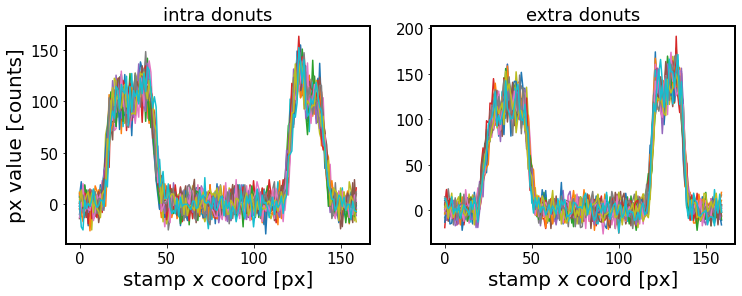

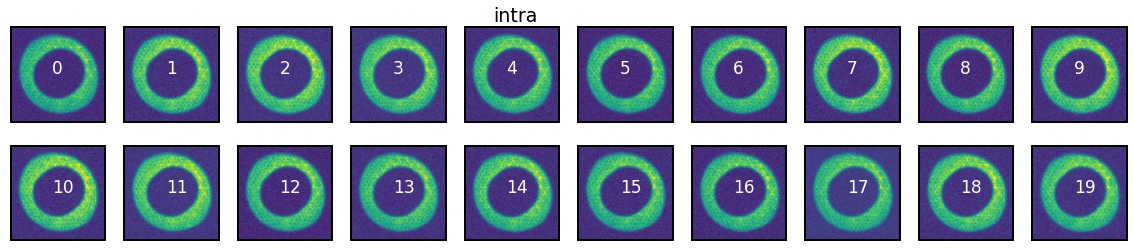

In [10]:
def plot_stamps(donutStamps, title='intra-focal',ncols=None,
               N=10, panel_width = 4, indices=None):
    #N = len(donutStamps)
    if indices is None:
        # take first N donuts
        indices = np.arange(N)
        
    else:  # infer the number of donuts to plot from the number of indices provided 
        N = len(indices)

    if ncols is None:
        nrows=5
        ncols=(N // nrows)
    else:
        nrows=(N//ncols)
        
    if N % nrows>0:
        ncols+=1
    fig,axs = plt.subplots(nrows,ncols, figsize=(ncols*panel_width,
                                                 nrows*panel_width))
    ax = np.ravel(axs)
    i = 0 
    zscale = ZScaleInterval()
    for j in indices:
        stamp = donutStamps[j]
        data =  stamp.stamp_im.getImage().getArray()
        vmin, vmax = zscale.get_limits(data)
        ax[i].imshow(data, vmin=vmin,vmax=vmax, origin='lower')
        ax[i].text(70,80, f'{i}', fontsize=17, c='white')
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        i += 1 
    M = nrows*ncols
    for i in range(N,M):
        ax[i].axis('off')
    fig.text(0.46, 0.89, title, fontsize=19)
    

fig,ax = plt.subplots(1,2,figsize=(12,4))
for j in intra_indices:
    ax[0].plot(donutStampsIntra[j].stamp_im.getImage().getArray()[100,:])
for k in extra_indices:
    ax[1].plot(donutStampsExtra[k].stamp_im.getImage().getArray()[100,:])

ax[0].set_title('intra donuts')
ax[1].set_title('extra donuts')
ax[0].set_ylabel('px value [counts]')
ax[1].set_xlabel('stamp x coord [px]')
ax[0].set_xlabel('stamp x coord [px]')

plot_stamps(donutStampsIntra, title='intra', ncols=10, N=None, panel_width=2,
           indices=intra_indices)
#plot_stamps(donutStampsExtra, title='extra', ncols=5)

In [35]:
group = 'A'
pixel_stack = 'sum'

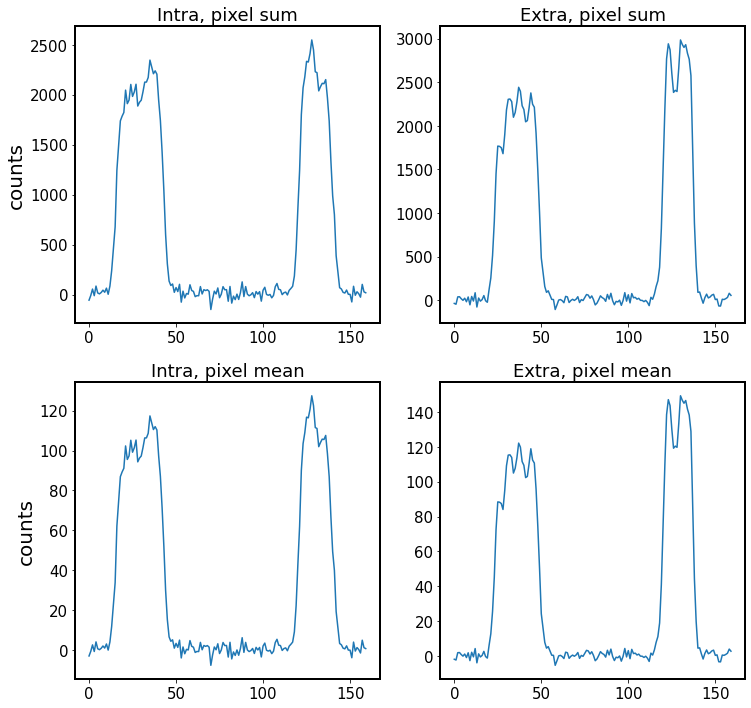

In [60]:



fig,ax = plt.subplots(2,2,figsize=(12,12))

row = 0
for pixel_stack in ['sum', 'mean'
                   ]:
    stacked_extra = stack_donuts_new(donutStampsExtra, indices=extra_indices,
                                    pixel_stack=pixel_stack)   
    stacked_intra = stack_donuts_new(donutStampsIntra, indices=intra_indices,
                                    pixel_stack=pixel_stack)   



    ax[row,0].plot(stacked_intra['donutStackedArray'][100,:])
    ax[row,1].plot(stacked_extra['donutStackedArray'][100,:])
    
    ax[row,0].set_title(f'Intra, pixel {pixel_stack}')
    ax[row,1].set_title(f'Extra, pixel {pixel_stack}')
    
    ax[row,0].set_ylabel('counts')
    row += 1 
  

The structure is very similar, but the count level is different since we've done averaging rather than summing on the pixel level... 

Would be very interesting to compare the Zk results of summing vs averaging! 



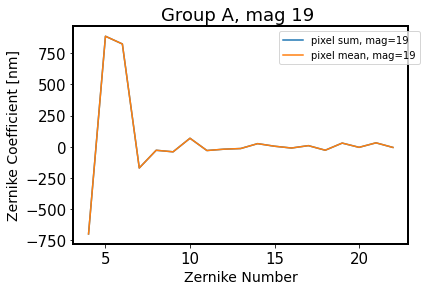

In [74]:
name = 'A'
mag = 19
#for mag in range(15,20):
for pixel_stack in ['sum', 'mean']:
    fname = f'store_wfsGrid_{mag}_extra_intra_group_{name}_{coCenterText}_{pixel_stack}.npy'
    fpath = os.path.join('DM-36218',fname)

    store = np.load(fpath, allow_pickle=True).item()
    zks =  store[14]['zer4UpNm']

    plt.plot(np.arange(4, 23), zks, label=f'pixel {pixel_stack}, mag={mag}')

# for the moment the summed ones do not have that in the filename ...
# pixel_stack = 'sum'
# fname = f'store_wfsGrid_{mag}_extra_intra_group_{name}_{coCenterText}.npy'
# fpath = os.path.join('DM-36218',fname)

# store = np.load(fpath, allow_pickle=True).item()
# zks_sum =  store[14]['zer4UpNm']

# plt.plot(np.arange(4, 23), 1000*zks_sum, label=f'pixel {pixel_stack}')

plt.title(f'Group {name}, mag {mag} ')
plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', 
        size=14)
plt.legend(bbox_to_anchor=[1.05, 1.], ncol=1)




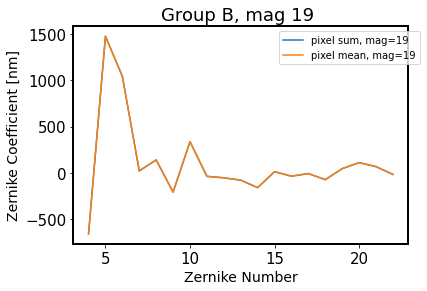

In [13]:
name = 'B'
mag = 19
coCenterText = 'noCocenter'
#for mag in range(15,20):
for pixel_stack in ['sum', 'mean']:
    fname = f'store_wfsGrid_{mag}_extra_intra_group_{name}_{coCenterText}_{pixel_stack}.npy'
    fpath = os.path.join('DM-36218',fname)

    store = np.load(fpath, allow_pickle=True).item()
    zks =  store[14]['zer4UpNm']

    plt.plot(np.arange(4, 23), zks, label=f'pixel {pixel_stack}, mag={mag}')

# for the moment the summed ones do not have that in the filename ...
# pixel_stack = 'sum'
# fname = f'store_wfsGrid_{mag}_extra_intra_group_{name}_{coCenterText}.npy'
# fpath = os.path.join('DM-36218',fname)

# store = np.load(fpath, allow_pickle=True).item()
# zks_sum =  store[14]['zer4UpNm']

# plt.plot(np.arange(4, 23), 1000*zks_sum, label=f'pixel {pixel_stack}')

plt.title(f'Group {name}, mag {mag} ')
plt.xlabel('Zernike Number', size=14)
plt.ylabel('Zernike Coefficient [nm]', 
        size=14)
plt.legend(bbox_to_anchor=[1.05, 1.], ncol=1)




Does it make sense that they are bitwise-identical? I see that the images used are not identical, so I wonder...

In [66]:
zks_sum

array([-6.81572405e+02,  8.75587891e+02,  9.26961303e+02, -1.16175063e+02,
       -7.47050560e+01, -1.89049752e+01,  4.17521974e+01, -4.09185574e+01,
       -4.65922667e+01, -2.32939920e+01,  1.71122519e+01, -1.38888213e+01,
        5.03240481e-01,  3.85699257e+00, -2.28756836e+01,  2.97621939e+01,
        1.05019103e+01,  2.25139991e+01, -8.48072200e+00])

In [67]:
zks_mean

array([-6.81572405e+02,  8.75587891e+02,  9.26961303e+02, -1.16175063e+02,
       -7.47050560e+01, -1.89049752e+01,  4.17521974e+01, -4.09185574e+01,
       -4.65922667e+01, -2.32939920e+01,  1.71122519e+01, -1.38888213e+01,
        5.03240481e-01,  3.85699257e+00, -2.28756836e+01,  2.97621939e+01,
        1.05019103e+01,  2.25139991e+01, -8.48072200e+00])

They're bitwise identical! Really interesting ... 

In [ ]:
Plot the contribution to PSF FWHM using the ts_phosim PR#72 (tickets/DM-33115)

In [ ]:
import importlib
importlib.reload()

In [11]:
from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import (
    convertZernikesToPsfWidth,
    getPsfGradPerZernike,
)

## Test the stacking vs pairing results for group A and B as compared to Bryce's notebook 

The notebook using corner WFS simulation https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/aos/vignetting/wepVignettedPerformanceLimits.ipynb 
    
    
    

First, show that the OPD we're comparing against is the correct one - plot for each detector, the mid-point OPD, the grid mean, and the gridded  values. 

In [27]:
import yaml
import os
import numpy as np
from scipy.ndimage import rotate
from astropy.table import Table

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.patheffects as patheffects

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [28]:
mag=16

# read the data for OPD grid 
# this has data for all four corners 
imgDir = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/iter0/img/'
opdDir = os.path.join(imgDir,'opd_grid/' )
zkFileName = 'opdGrid.zer'

opdZkFilePath = os.path.join(imgDir, zkFileName)
opdDataGridAll = np.loadtxt(opdZkFilePath)


# each donut opd table is for a different corner 
# hence need to select all indices to a given OPD grid ... 
opds_per_corner = {}
for sensor in ['R00','R40','R04','R44']:
    fname = f'DM-36218/wfs_grid_{mag}_{sensor}_donut_info_opd.txt'
    donut_opd = Table.read(fname,format='ascii')
    ids = donut_opd['idToOpdGrid'].value
    opds_per_corner[sensor] = opdDataGridAll[ids]


In [29]:
iterN=0
opdZkFilePath = f'/sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/wfs_grid_{mag}/iter{iterN}/img/opd.zer'
opdData = np.loadtxt(opdZkFilePath)

# Load the OPD "Truth" information
opdDataBryce = np.genfromtxt('/sdf/group/rubin/ncsa-project/project/aos/vignetting_tests/vignette_test_no_rot/iter0/img/opd.zer')
opd_idx_dict = {'191':2, '195':1, '199':3, '203':0}

indexOpdData = {'R44':0,'R40':1, 'R00':2, 'R04':3}

indexOpdData2 = {'R44':0,'R04':1, 'R00':2, 'R40':3}  # like Bryce's 
opd_idx_dict = {'203':0, '195':1, '191':2,  '199':3, } # from Bryce 

sensor_to_detector = {'R44':203, 'R04':195, 'R00':191, 'R40':199}


Check whether Bryce's OPDs are same as mine....

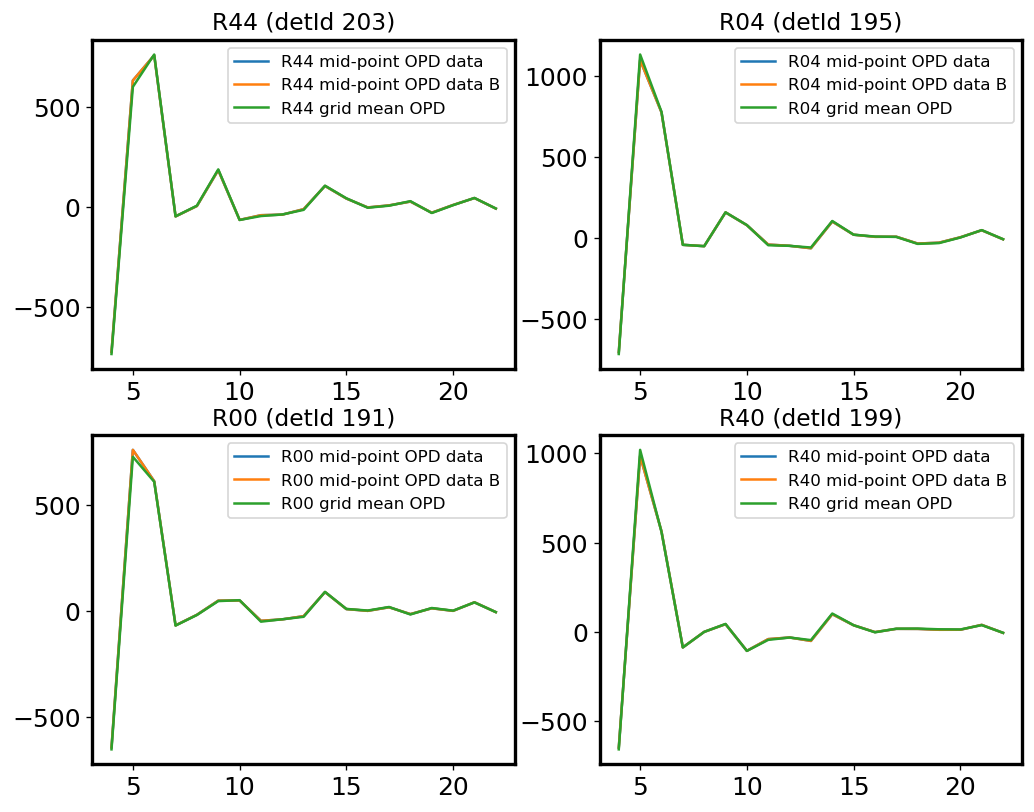

In [7]:
fig,axs = plt.subplots(2,2,figsize=(10,8), dpi=120)
ax = np.ravel(axs)

i=0
for sensor in indexOpdData2.keys():
    opdDataSensor = opdData[indexOpdData2[sensor]]
    opdDataSensorBryce = opdDataBryce[indexOpdData2[sensor]]
    
    ax[i].plot(np.arange(4, 23), 1000*opdDataSensor, label=f'{sensor} mid-point OPD data')
    ax[i].plot(np.arange(4, 23), 1000*opdDataSensorBryce, label=f'{sensor} mid-point OPD data B')
    
    ax[i].plot(np.arange(4,23), 1000*np.mean(opds_per_corner[sensor],axis=0), label=f'{sensor} grid mean OPD')
    ax[i].legend()
    detector = sensor_to_detector[sensor]
    ax[i].set_title(f'{sensor} (detId {detector})', fontsize=14)
    i += 1 

Looks like indeed I swapped R40 with R0 .. Bryces indices to `opd.zer` actually match the grid mean much better. Ok, but for R00 this doesn't matter anyway. Proceed to plot the Zernikes on top of that.

Note that his simulation had only intra-focal donuts with increasing degree of vignetting  - the extra-focal donut actually was right in the center of the detector ... 

This also shows that Bryce's simulation had exactly the same "truth", i.e. OPD values. This is because the simulation seed is hard-coded , so each run of hte `imgCloseLoop` that has the same starting parameters (eg. default) starts with exactly the same perturbations. 

In [33]:
#Read the zernike results for stacking and averaging ... 
iterN=0
mag = 16 
pixel_stack = 'sum'
zks_per_corner = {}
for sensor in indexOpdData2.keys():
    # read the donut-opd table 
    fname = f'DM-36218/wfs_grid_{mag}_{sensor}_donut_info_opd.txt'
    donut_opd = Table.read(fname,format='ascii')

    for group in 'AB':
        
        key = sensor+group
        print(f'Reading zernikes for {key}')
        zks_per_corner[key] = {}

        # get the donut indices used for these groups
        indices = {}
        for defocal  in ['intra','extra']:
            m1 = donut_opd['group'] == group
            m2 = donut_opd['defocal'] == defocal
            indices[defocal] = donut_opd[m1&m2]['idToDonutStamps']
            zks_per_corner[key][defocal+'fieldRmean'] = np.mean(donut_opd[m1&m2]['fieldR'])
            
        # read the individual donut results
        coCenterText = 'noCocenter'
        zks=[]
        # there is the same number of intra as extra donuts, by design
        for k in range(len(indices['intra'])):
            i = indices['extra'][k]
            j = indices['intra'][k]
            fname = f'store_wfsGrid_{mag}_{sensor}_extra-{i}_intra-{j}_{coCenterText}.npy'
            fpath= os.path.join('DM-36218',fname)
            store = np.load(fpath, allow_pickle=True).item()
            zk = store[14]['zer4UpNm']
            zks.append(zk)
        zks_per_corner[key]['zks'] = zks

        # plot the stacked (combined) donuts
        fname = f'store_wfsGrid_{mag}_{sensor}_extra_intra_group_{group}_{coCenterText}_{pixel_stack}.npy'
        fpath= os.path.join('DM-36218',fname)
        store = np.load(fpath, allow_pickle=True).item()
        zkc = store[14]['zer4UpNm']
        zks_per_corner[key]['zkc'] = zkc
        
        
        

Reading zernikes for R44A
Reading zernikes for R44B
Reading zernikes for R04A
Reading zernikes for R04B
Reading zernikes for R00A
Reading zernikes for R00B
Reading zernikes for R40A
Reading zernikes for R40B


In [35]:
# store all zernikes per corner 
fname = f'store_wfsGrid_{mag}_{sensor}_all_zk.npy'
fpath= os.path.join('DM-36218',fname)
np.save(fpath, zks_per_corner,  )

Do the plot of mid-point OPD vs the Zernike coefficients:

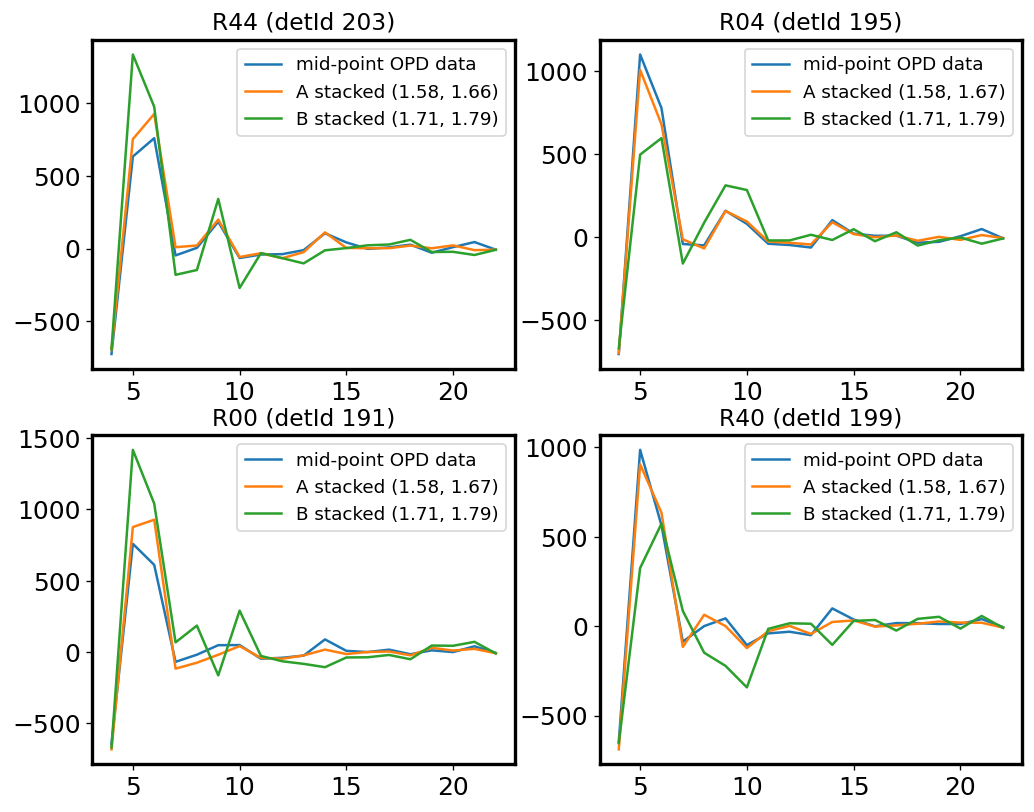

In [36]:
fig,axs = plt.subplots(2,2,figsize=(10,8), dpi=120)
ax = np.ravel(axs)

i=0
for sensor in indexOpdData2.keys():
    opdDataSensor = opdData[indexOpdData2[sensor]]
    
    ax[i].plot(np.arange(4, 23), 1000*opdDataSensor, label=f'mid-point OPD data')
    #ax[i].plot(np.arange(4,23), 1000*np.mean(opds_per_corner[sensor],axis=0), label=f'{sensor} grid mean OPD')
    for group in 'AB':
        key = sensor+group
        fieldRextra = zks_per_corner[key]['extrafieldRmean']
        fieldRintra = zks_per_corner[key]['intrafieldRmean']
        ax[i].plot(np.arange(4, 23), zks_per_corner[key]['zkc'], 
                   label=f'{group} stacked {np.round(fieldRextra,2),np.round(fieldRintra,2)}')
    ax[i].legend(fontsize=11)
    detector = sensor_to_detector[sensor]
    ax[i].set_title(f'{sensor} (detId {detector})', fontsize=14)
    i += 1 

Add to these Bryce's Zernikes - can't get them from the butler repo, as there are only two results per corner sensor (there are only two extra-focal donuts in his simulations). So we load the donuts, and run them through the pipeline fitting as above. 


Turns out that because of Bryce's update to obs_base formatter, it's expecting `DFC_DIST` in all donut stamp fits files, making all data created before August 2022 unreadable ... Be it his 

     /sdf/group/rubin/ncsa-project/project/aos/vignetting_tests/vignette_test_no_rot/phosimData/

or mine

    /sdf/group/rubin/ncsa-project/project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/

(which used the same underlying stellar grid... ) 


Let's run one iteration of `imgCloseLoop` again using the same input set of stars - most of the commands are identical as that in 


    cd /sdf/home/s/scichris/link_to_scichris/WORK/AOS/DM-36218
    cp /sdf/group/rubin/ncsa-project/project/scichris/aos/masks_DM-33104/wfs/vignetteTestSky.txt .
    
The slurm file contained


     python /project/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 230 --boresightDeg 0.0 0.0  --output /project/scichris/aos/masks_DM-33104/w
fs/vignetteSkyQckBgSunAlt/ --skyFile /project/scichris/aos/masks_DM-33104/wfs/vignetteTestSky.txt    --iterNum 1  

so I change it to 


    python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 100 --boresightDeg 0.0 0.0 --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/vignetteSkyNoBg/
    --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/vignetteTestSky.txt --iterNum 1
    
 (each node has 128 cores)    
    
The `runSlurmVig.sl` has:


    #!/bin/bash -l
    #SBATCH --partition roma
    #SBATCH --nodes 1
    #SBATCH --ntasks 100
    #SBATCH -t 100:00:00
    #SBATCH --job-name vig

    echo "starting at `date` on `hostname`"

    pwd

    python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 100 --boresightDeg 0.0 0.0 --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/vignetteSkyNoBg/  --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/vignetteTestSky.txt --iterNum 1

    echo "ended at `date` on `hostname`"
    
I check the progress with 

    more slurm-548935.out
    
The run fails (because I tried to run it while `ts_wep` was reverted to `v2.5.1`..)


But it turns out I should be able to read the donut stamps and use Bryce's code to get Zernikes that he used in his notebook (because it was written for `2.5.1` ... ) 



Set `ts_wep` to `v2.5.1` , run code from https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/aos/vignetting/wepVignettedPerformanceLimits.ipynb .

First , load the donuts to a dict:

In [57]:
import algoritm_functions as func

#repo_dir = '/sdf/group/rubin/ncsa-project/project/scichris/aos/masks_DM-33104/wfs/vignetteSkyQckBg/phosimData/'
repo_dir = '/sdf/group/rubin/ncsa-project/project/aos/vignetting_tests/vignette_test_no_rot/phosimData/'
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'
instName='lsst'
opticalModel = 'offAxis'
sizeInPix = 160 
solver = 'exp' 
debugLevel = 0 

detectorDonutsExtra = {}
detectorDonutsIntra = {}

for sensor in ['R00','R04','R40','R44']:
    print(sensor)
    # read in all the donuts 
    donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)

    detectorDonutsExtra[sensor] = donutStampsExtra
    detectorDonutsIntra[sensor] = donutStampsIntra


Initialize the  `EstimateZernikes` task and run it choosing the same extra-focal donut, and i-th intra-focal donut:

In [58]:
from lsst.ts.wep.task.EstimateZernikesCwfsTask import EstimateZernikesCwfsTask, EstimateZernikesCwfsTaskConfig
# Initiate the task to estimate the Zernikes
zernConfig = EstimateZernikesCwfsTaskConfig()
zernTask = EstimateZernikesCwfsTask(config=zernConfig)

from lsst.ts.wep.task.DonutStamps import DonutStamps
detectorZernikes = {}
for sensor in detectorDonutsExtra.keys():
    donutsExtra = detectorDonutsExtra[sensor]
    donutsIntra = detectorDonutsIntra[sensor]
    zernVals = []
    for i in range(len(donutsIntra)):
        zernEstimate = zernTask.estimateZernikes([donutsExtra[0]], [donutsIntra[i]])
        zernVals.append(zernEstimate)
    detectorZernikes[sensor] = zernVals
    
    

While we have all the donuts, we can also find their fieldX, fieldY, and thus calculate the field distance. Use this occasion to ensure that Bryce's way of finding their distance from the center of the focal plane yields the same results ... 

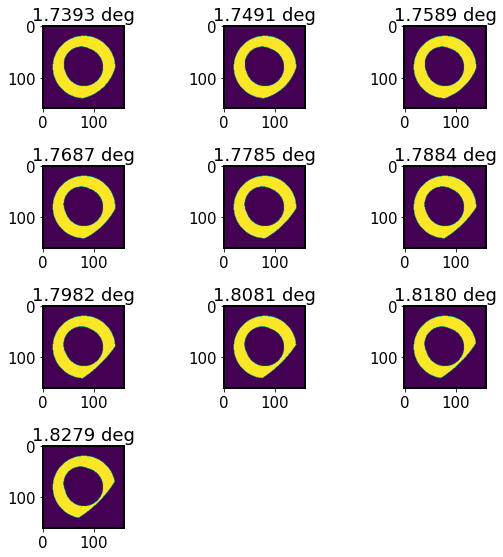

In [59]:
instDataPath = os.path.join(getConfigDir(), 'cwfs', 'instData')
maskDataPath = os.path.join(getConfigDir(), 'cwfs', 'instData', 'lsst', 'maskMigrate.yaml')
inst = Instrument(instDataPath)
inst.config(CamType.LsstCam, 160)

fig = plt.figure(figsize=(8, 8))
distToCenterVals = []
for i in range(10):
    fig.add_subplot(4, 3, i+1)
    dStamp = donutStampsIntra[i]
    dStamp.makeMasks(inst, 'offAxis', 0, 1)
    plt.imshow(dStamp.mask_comp.getArray())
    ra = donutStampsIntra[i].sky_position[0].asDegrees()
    dec = donutStampsIntra[i].sky_position[1].asDegrees()
    distToCenter = np.sqrt(ra**2 + dec**2)
    distToCenterVals.append(distToCenter)
    plt.title(f'{distToCenter:.4f} deg')
plt.tight_layout()

In [60]:
distToCenterVals = []
for i in range(10):
    donutStamp = donutStampsIntra[i]
    ra = donutStamp.sky_position[0].asDegrees()
    dec = donutStamp.sky_position[1].asDegrees()
    
    fieldX, fieldY = donutStamp.calcFieldXY()[::-1]  
    fieldR = np.sqrt(fieldX**2. + fieldY**2.)
    distToCenter = np.sqrt(ra**2 + dec**2)
    print(distToCenter,fieldR )

1.7392759987995003 1.7404331235533665
1.7490766135306937 1.7502339563630265
1.7588885695233794 1.7600846572740771
1.768711678030085 1.7699479845621326
1.7785457542610479 1.7797822529892684
1.7883906172869506 1.7896272986450437
1.7982460899443102 1.7994829446414753
1.8081119987434406 1.8093490177562637
1.8179881737789165 1.819225348343507
1.8278744486424663 1.8291509796425118


They're not identical, but close. The advantage of using `calcFieldXY` is that we can do that for all four corners... Store both intra-focal and extra-focal donut distances... 

In [61]:
def get_distance(donutStamp):
    fieldX, fieldY = donutStamp.calcFieldXY()[::-1]  
    fieldR = np.sqrt(fieldX**2. + fieldY**2.)
    return fieldR

detectorDistances = {}

for sensor in detectorDonutsExtra.keys():
    detectorDistances[sensor] = {'intra':[], 'extra':[]}
    donutsExtra = detectorDonutsExtra[sensor]
    donutsIntra = detectorDonutsIntra[sensor]
    
    for donutStamp in donutsExtra:
         detectorDistances[sensor]['extra'].append(get_distance(donutStamp))  
    for donutStamp in donutsIntra:
         detectorDistances[sensor]['intra'].append(get_distance(donutStamp))     
 

Ok, now we have both Zernike results and donut distances calculated. Save that information to a `.npy` file, and revert to current `ts_wep` version....

R00
R04
R40
R44


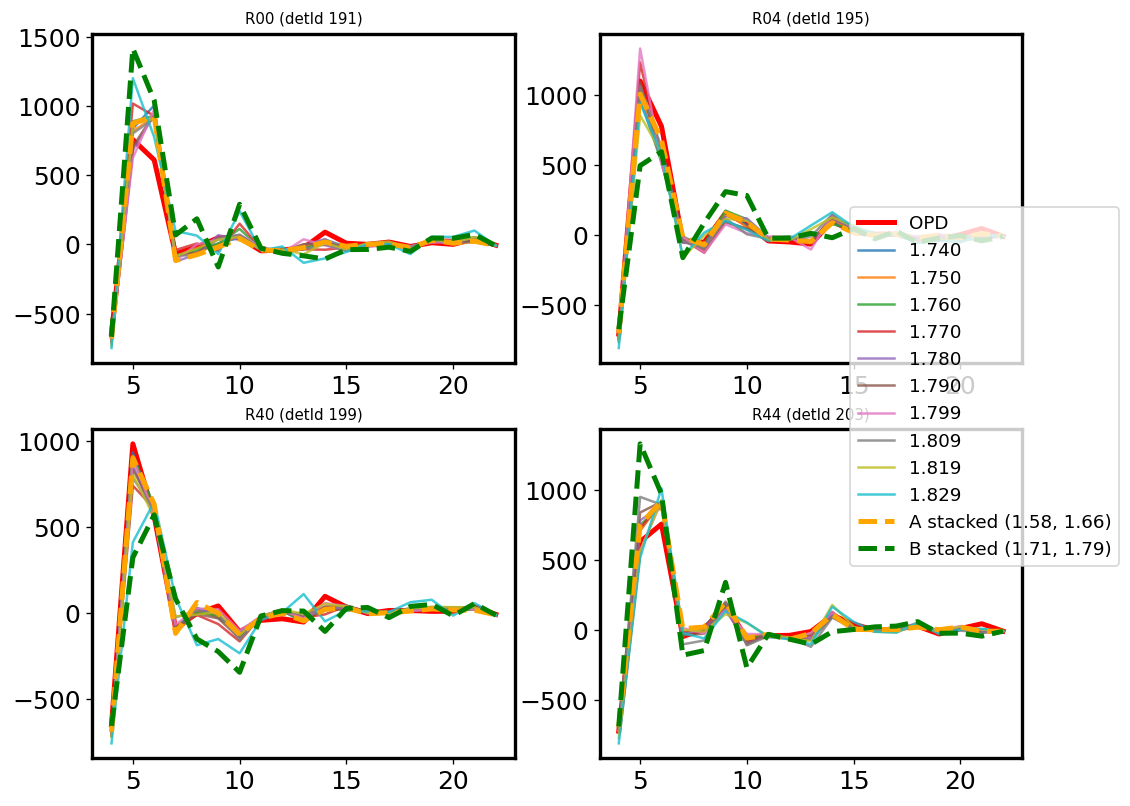

In [79]:
fig,axs = plt.subplots(2,2,figsize=(10,8), dpi=120)
ax = np.ravel(axs)

i=0
for sensor in ['R00', 'R04','R40', 'R44']:
    print(sensor)
    opdDataSensor = opdData[indexOpdData2[sensor]]
    
    ax[i].plot(np.arange(4, 23), 1000*opdDataSensor, lw=3, label=f'OPD',c='red')
    #ax[i].plot(np.arange(4,23), 1000*np.mean(opds_per_corner[sensor],axis=0), label=f'{sensor} grid mean OPD')
    
      # add Bryce's results
    zernVals = detectorZernikes[sensor]
    distVals = detectorDistances[sensor]['intra']
    for j in range(len(zernVals)):
        ax[i].plot(np.arange(4, 23), 1000*zernVals[j][0], label=f'{distVals[j]:.3f}',
                  alpha=0.8)
        
        
    for group, color in zip('AB',['orange','green']):
        key = sensor+group
        fieldRextra = zks_per_corner[key]['extrafieldRmean']
        fieldRintra = zks_per_corner[key]['intrafieldRmean']
        ax[i].plot(np.arange(4, 23), zks_per_corner[key]['zkc'], ls='--',lw=3,c=color,
                   label=f'{group} stacked {np.round(fieldRextra,2),np.round(fieldRintra,2)}')
        
  
        

    detector = sensor_to_detector[sensor]
    ax[i].set_title(f'{sensor} (detId {detector})', fontsize=9)
    i += 1 
ax[3].legend(bbox_to_anchor=[1.25, 1.7], fontsize=11)

Ok, so initially they didn't look correct because I was using the quick background simulation rather than no background ... So now we see that they are consistent - group B gets much closer to the highest-distance donuts from Bryce's simulation. But note that his simulation included only intra-focal donuts with varying vignetting - the extra-focal donut was in the center of the chip. 